### The easiest way to run this notebook is use Docker. 

See instructions here [https://github.com/EarthByte/spatial-temporal-exploration/blob/master/README.md#docker](https://github.com/EarthByte/spatial-temporal-exploration/blob/master/README.md#docker)

## Step 1: 
#### Generate Subduction Convergence Kinematics Statistics 

The [convergence.py](convergence.py) depends on the PlateTectonicTools, which can be found at [https://github.com/EarthByte/PlateTectonicTools.git](https://github.com/EarthByte/PlateTectonicTools.git).
    

The configuration parameters for convergence.py can be found in [parameters.py](parameters.py).

Relevant parameters:
* plate_tectonic_tools_path -- the path to the PlateTectonicTools code
* rotation_files -- location of the rotation files
* topology_files -- location of the topology files
* threshold_sampling_distance_degrees -- the default threshold sampling distance along trenches (subduction zones)
* time.start -- start time
* time.end -- end time
* time.step -- time interval between steps
* velocity_delta_time -- time interval for velocity calculation
* anchor_plate_id - the anchor plate id
* convergence_data_filename_prefix -- the prefix of the output files
* convergence_data_filename_ext -- the extension name of the output files
* convergence_data_dir -- the name of the folder in which the output files go


In [ ]:
%%capture --no-stdout

import subprocess
import convergence 

print('running convergence...')
print('this may take a while, be patient...')
print('')

#run the convergence script
#this will generate a bunch of Subduction Convergence Kinematics Statistics files
#by default the files are placed in ./convergence_data
convergence.run_it()

# now, let's list all the output files
o = subprocess.check_output(['ls', '-ltlh', './convergence_data'])
print(str(o).replace('\\n','\n')[2:-2])


#### The columns in the csv files are:

* 0 lon
* 1 lat
* 2 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
* 3 subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
* 4 trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
* 5 trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
* 6 length of arc segment (in degrees) that current point is on
* 7 trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
* 8 subducting plate ID
* 9 trench plate ID
* 10 distance (in degrees) along the trench line to the nearest trench edge
* 11 the distance (in degrees) along the trench line from the start edge of the trench
* 12 convergence velocity orthogonal (in cm/yr)
* 13 convergence velocity parallel  (in cm/yr) 
* 14 the trench plate absolute velocity orthogonal (in cm/yr)
* 15 the trench plate absolute velocity orthogonal (in cm/yr)
* 16 the subducting plate absolute velocity magnitude (in cm/yr)
* 17 the subducting plate absolute velocityobliquity angle (in degrees)
* 18 the subducting plate absolute velocity orthogonal       
* 19 the subducting plate absolute velocity parallel

In [ ]:
%matplotlib inline

import requests, os

import pygplates

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

#now we plot the Subduction Convergence Kinematics Statistics in a map

trench_file = './convergence_data/subStats_0.00.csv'
trench_data= np.genfromtxt(trench_file)

#change this number to see the trench colored by different property. 
#The meaning of this number can be found in the cell above
color_by = 11

#now, get topological plates boundaries
data_dir = '../data/'
rotation_model = pygplates.RotationModel(data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS.rot')
topology_features = [data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml.gz',
                     data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml.gz']

time = 0
resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, 
                             shared_boundary_sections)

geoms = []           
for t in resolved_topologies:
    geoms.append(t.get_resolved_boundary())

#now, plot the data in a map    
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
for geom in geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='white', linewidth=.5, #the topological plates boundaries in white
         transform=ccrs.Geodetic(),
    )
#the subduction sample points are colored by property value. see "color_by" above
cb=ax.scatter(trench_data[:,0], trench_data[:,1], 30, marker='.', c=trench_data[:,color_by], cmap=plt.cm.jet)
plt.title('Present-day Subduction Zones')
fig.colorbar(cb, shrink=0.5)
plt.show()

#### Plot a reconstruction map
This is a reconstructed map with a paleo-age grid, paleo-coastlines, plate boundaries and subduction teeth.

reconstructing geometries...


/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1752: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


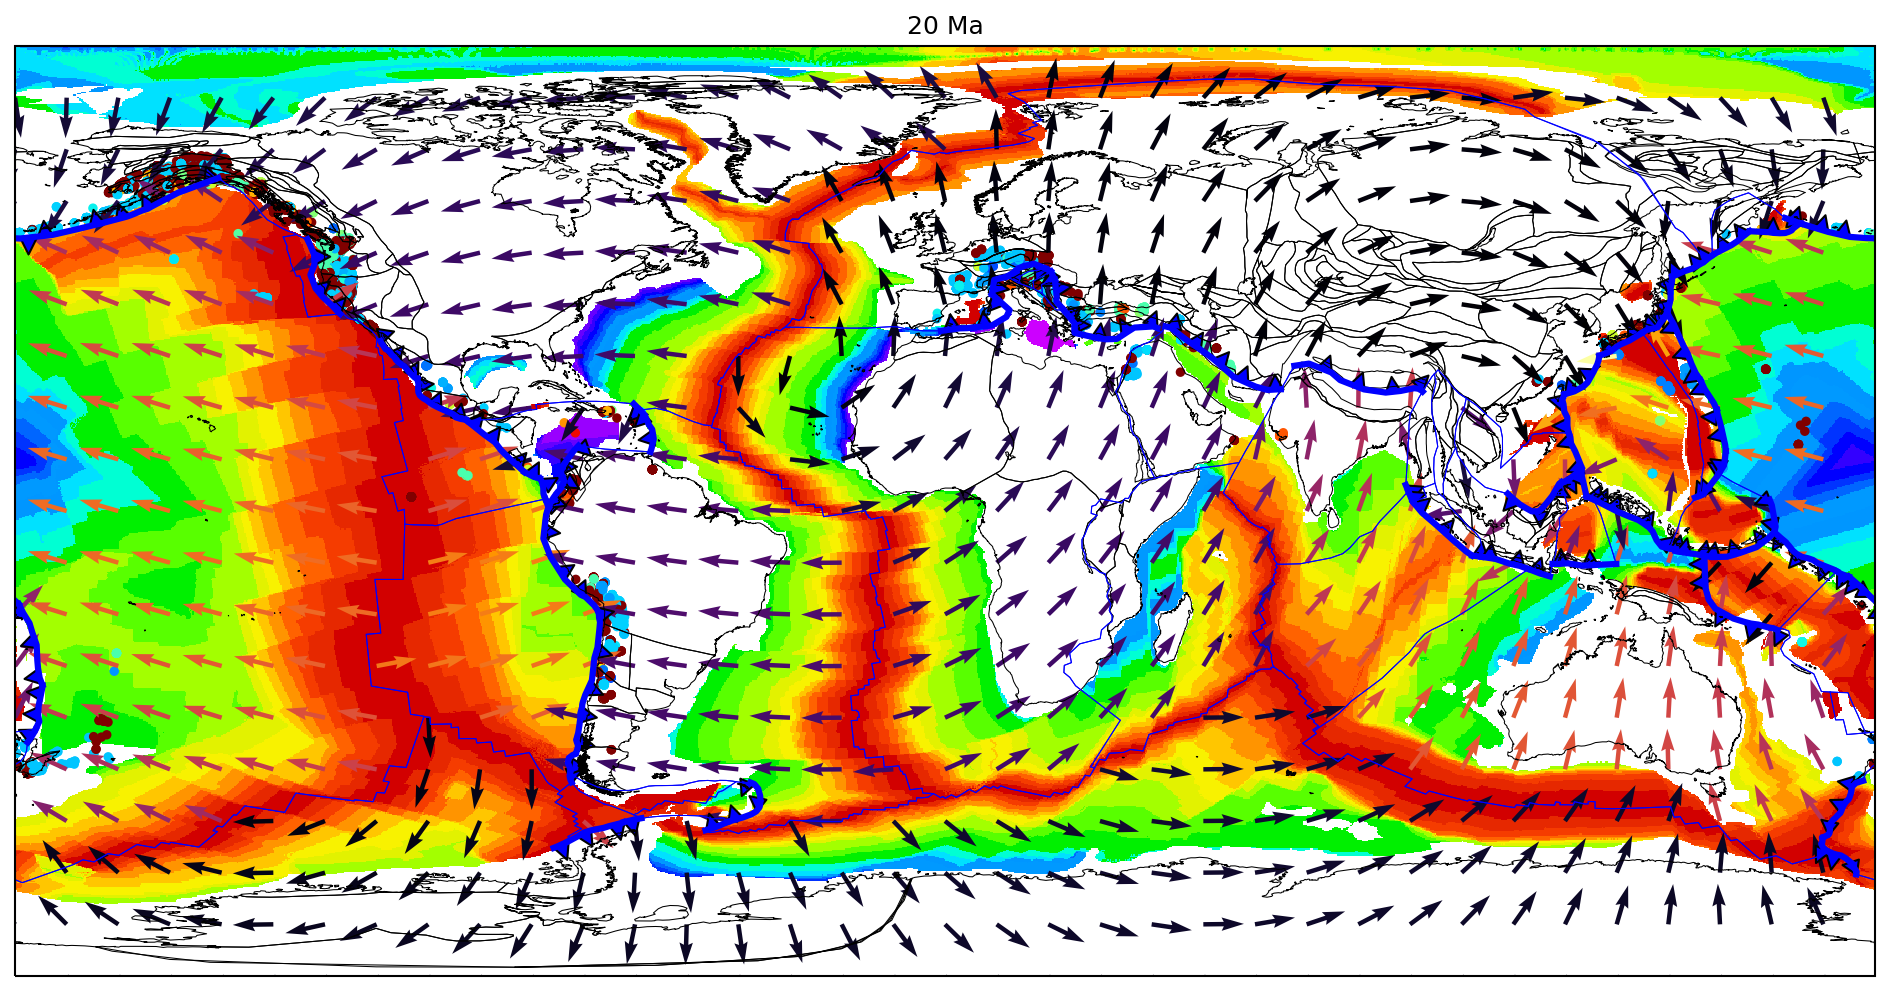

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
from netCDF4 import Dataset
from shapely.geometry.polygon import LinearRing

import Utils, pygplates

time = 20
draw_velocity_vectors = True
draw_earthchem_CU_deposits = True

#change the extent to see specific area
#map_extent = [-85, -30, -55, 15]
map_extent = [-180, 180, -90, 90]

agegrid_file = Utils.download_agegrid(time)
agegrid_cmap = Utils.get_age_grid_color_map_from_cpt('agegrid.cpt')

#reconstruct coastlines and topology
print("reconstructing geometries...")
data_dir = '../data/'
rotation_model = pygplates.RotationModel(data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS.rot')
topology_features = [data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml.gz',
                     data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml.gz']

resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, 
                             shared_boundary_sections)

#coastlines
reconstructed_geometries = []
pygplates.reconstruct(
                data_dir + 'Shapefiles/Coastlines/Global_coastlines_2015_v1_low_res.shp', 
                rotation_model, 
                reconstructed_geometries, 
                time, 0)

if draw_earthchem_CU_deposits:
    #CU deposits from EarchChem
    earthchem_cu_geometries = []
    pygplates.reconstruct(
                    data_dir + 'EarthChem_CU.gpmlz', 
                    rotation_model, 
                    earthchem_cu_geometries, 
                    time, 0)

#subduction zones
subduction_geoms=[]
Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)

#velocity vectors
x,y, u,v = Utils.get_velocity_x_y_u_v(time,rotation_model,topology_features)
       
# plot the map
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent(map_extent)
img = Dataset(agegrid_file) #age grid
ax.imshow(np.roll(img.variables['z'],1800), origin='lower', transform=ccrs.PlateCarree(),
          extent=[-180, 180, -90, 90], cmap=agegrid_cmap)

#plot coastlines
for geom in reconstructed_geometries:
    lat, lon =zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='black', linewidth=.5, #the coastlines in black
         transform=ccrs.Geodetic(),
    )

if draw_earthchem_CU_deposits:
    #plot CU deposits
    ages=[]
    lons=[]
    lats=[]
    for geom in earthchem_cu_geometries:
        lat, lon = geom.get_reconstructed_geometry().to_lat_lon()
        begin_time, end_time = geom.get_feature().get_valid_time()
        lons.append(lon)
        lats.append(lat)
        ages.append(begin_time)
    ages = np.array(ages)
    ages[ages>230]=230
    plt.scatter(lons, lats, 50, marker='.', c=ages, transform=ccrs.Geodetic(), 
                vmin=0, vmax=100, cmap=plt.cm.jet)
    
#plot topological plates boundaries
for t in resolved_topologies:
    lat, lon =zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='blue', linewidth=.5, #the topological plates boundaries in blue
         transform=ccrs.Geodetic(),
    )
 
#plot subduction zones
for geom, aspect in subduction_geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='blue', linewidth=3, #the subduction zones in blue
         transform=ccrs.Geodetic(),
    )
    teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
    for tooth in teeth:
        ring = LinearRing(tooth)
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='b', edgecolor='black', alpha=1)

 
if draw_velocity_vectors:
    #draw the velocity vectors
    #Some arrows are long and some are very short. To make the plot clearer, we nomalize the velocity magnitude.
    #And use color to denote the different speed.
    u = np.array(u)
    v = np.array(v)
    mag = np.sqrt(u*u+v*v)
    u = u/mag
    v = v/mag
    ax.quiver(x, y, u, v, mag,transform=ccrs.PlateCarree(),cmap='inferno')    


plt.title(f'{time} Ma')
plt.show()   
   


#### This is the end of step 1 and now open the step 2 notebook
[2_Prepare_Input_File_For_Coregistration.ipynb](2_Prepare_Input_File_For_Coregistration.ipynb)